## Building model for used cars price prediction
### Action plan:
1. Loas data 
2. Freature engineering - generate new features
3. Featire transform
4. Make pipline
5. Fit and tuning models
6. Interpret result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
glob('../../data/1/source_data/clean_data_offer_used*')

['../../data/1/source_data/clean_data_offer_used 2020-10-19 19:12.csv',
 '../../data/1/source_data/clean_data_offer_used 2020-09-04 13:17.csv',
 '../../data/1/source_data/clean_data_offer_used 2020-03-02 20:04.csv',
 '../../data/1/source_data/clean_data_offer_used 2020-10-19 19:10.csv',
 '../../data/1/source_data/clean_data_offer_used 2020-03-03 17:14.csv']

### 1. Load data

In [3]:
# load data clean_data_offer_used 2020-03-03 17:09.csv
offer_data = pd.read_csv('../../data/1/source_data/clean_data_offer_used 2020-10-19 19:12.csv', index_col=0)

In [4]:
offer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244659 entries, 0 to 246323
Data columns (total 20 columns):
producer                 244659 non-null object
model_name               244659 non-null object
price                    244659 non-null int64
age                      244659 non-null int64
kmage                    244659 non-null int64
region                   244659 non-null object
engine_volume            244659 non-null float64
engine_power             244659 non-null float64
fuel                     244659 non-null object
gear                     244659 non-null object
case                     244659 non-null object
drive_type               244659 non-null object
color                    244659 non-null object
offer_count_by_region    244659 non-null int64
lat                      244659 non-null float64
lng                      244659 non-null float64
macro_name               244659 non-null object
origin_of_producer       244659 non-null object
platform                 

### 2. Feature engineering
У нас уже есть признак общего количество предложений авто в регионе, целесообразно добавить признак количества авто данной модели и количества авто данной модели в регионе, что бы модель могла учесть объем предложения и популярность модели (или доступность запасных частей и сервиса в регионе)

Добавим год выпуска в качестве категориальной переменной и возраст в качестве численной

In [5]:
# количество авто данной модели всего
offer_count_model = offer_data['model_name'].value_counts().to_frame().reset_index()
offer_count_model.columns = ['model_name', 'offer_count_by_model']

In [6]:
# количество авто данной модели в регионе
offer_count_model_macro_region = offer_data.groupby(['model_name', 'macro_name'], as_index=False)\
                                           .count()[['model_name', 'macro_name', 'producer']]
offer_count_model_macro_region.columns = ['model_name', 'macro_name', 'offer_count_by_model_macro_region']

In [7]:
# количество авто данной производителя в регионе
offer_count_prod_macro_region = offer_data.groupby(['producer', 'macro_name'], as_index=False)\
                                           .count()[['producer', 'macro_name', 'model_name']]
offer_count_prod_macro_region.columns = ['producer', 'macro_name', 'offer_count_by_prod_macro_region']

In [8]:
offer_data.shape

(244659, 20)

In [9]:
offer_data = pd.merge(offer_data, offer_count_model, on='model_name')
offer_data = pd.merge(offer_data, offer_count_model_macro_region, on=['model_name', 'macro_name'])
offer_data = pd.merge(offer_data, offer_count_prod_macro_region, on=['producer', 'macro_name'])

In [10]:
offer_data.head(1).T

,0
producer,BMW
model_name,BMW 1 серия II (F20/F21) 116i
price,850000
age,2012
kmage,81000
region,Одинцово
engine_volume,1.6
engine_power,136
fuel,Бензин
gear,автомат


### 2.1 Feature transform

In [11]:
category_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype == 'object']
print(category_columns)
numeric_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype != 'object']
print(numeric_columns)

['producer', 'model_name', 'region', 'fuel', 'gear', 'case', 'drive_type', 'color', 'macro_name', 'origin_of_producer', 'platform']
['price', 'age', 'kmage', 'engine_volume', 'engine_power', 'offer_count_by_region', 'lat', 'lng', 'specific_power', 'offer_count_by_model', 'offer_count_by_model_macro_region', 'offer_count_by_prod_macro_region']


In [26]:
# # исключим избыточные категориальные признаки
# exclude_cat = ['region', 'norm_adress']
# category_columns = [x for x in category_columns if x not in  exclude_cat]
# print(category_columns)
# # исключим избыточные численные признаки - 
# # координаты дублируют аресную информацию и будут коррелированый с макрорегионом
# exclude_num = ['lat', 'lng']
# numeric_columns = [x for x in numeric_columns if x not in  exclude_num]
# print(numeric_columns)

### OHE
Напишем функцию для упрощения кодирования переменных.

# TODO 
Переделать данный шаг, рассмотреть возможность порядкового кодирования для  бустинговых моделей.
 

In [12]:
%%time
# categorical data trransformation

data_ohc = offer_data[category_columns + numeric_columns].copy()

print('Базовым авто будет авто со следующими характеристиками: ')
print('-'*60)

# encode labels
for col in category_columns:
    # мы удаляем 1 столбец "дамми" переменной что бы исключить мультиколлениарность
    # этом "базовым авто" будет 
    print(sorted(offer_data[col].unique())[0])
    new_df = pd.get_dummies(offer_data[col], drop_first=True)
    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)
    data_ohc = data_ohc.drop(col, axis=1)

print('-'*60)



Базовым авто будет авто со следующими характеристиками: 
------------------------------------------------------------
BMW
BMW 1 серия  I (E81/E82/E87/E88) 116i
Абадзехская
Бензин
автомат
внедорожник 3 дв.
задний
бежевый
Авадан
France
BMW 1
------------------------------------------------------------
CPU times: user 14.9 s, sys: 3.47 s, total: 18.4 s
Wall time: 18.4 s


In [13]:
%%time
# numeric feature transformation
for col in [x for x in numeric_columns if x != 'price']:
    #quant_transf = QuantileTransformer(output_distribution='normal')
    #quant_transf.fit_transform(offer_data[[col]])
    scaler = StandardScaler()
    data_ohc[[col]] = scaler.fit_transform(offer_data[[col]])

CPU times: user 295 ms, sys: 26.6 ms, total: 321 ms
Wall time: 320 ms


### 3.1 Train test split

In [14]:
%%time

y_col = 'price'

cols = [x for x in data_ohc.columns if x != y_col]
X_data = data_ohc[cols]
y_data = data_ohc[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.4, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, random_state=42)

CPU times: user 4.72 s, sys: 352 ms, total: 5.08 s
Wall time: 5.07 s


In [15]:
print(X_data.shape)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(244659, 6525)
(146795, 6525)
(48932, 6525)
(48932, 6525)


## 3. Model fitting
### 3.1. Baseline constant model

In [16]:
y_pred_const = pd.Series(y_train.median(), index=y_test.index)

In [17]:
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(y_test, y_pred_const)))

Mean Absolute Error : 394129.23


### Resume:
Constant model error on 394k in price of car

In [18]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1).iloc[:25]
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()
    
    
def plot_prediction(y_pred, y_true):
    plt.figure(figsize=(12,8))
    plt.scatter(y_pred, y_true, alpha=0.6)
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    plt.grid()
    plt.show()

### 3.2 Linear Models

In [20]:
%%time
lasso = Lasso()
lasso.fit(X_train, y_train)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1512370065094720.0, tolerance: 5945264158966.658
  positive)


CPU times: user 1h 21min 59s, sys: 16min 27s, total: 1h 38min 26s
Wall time: 10min 23s


In [21]:
predictions = lasso.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 79652.18


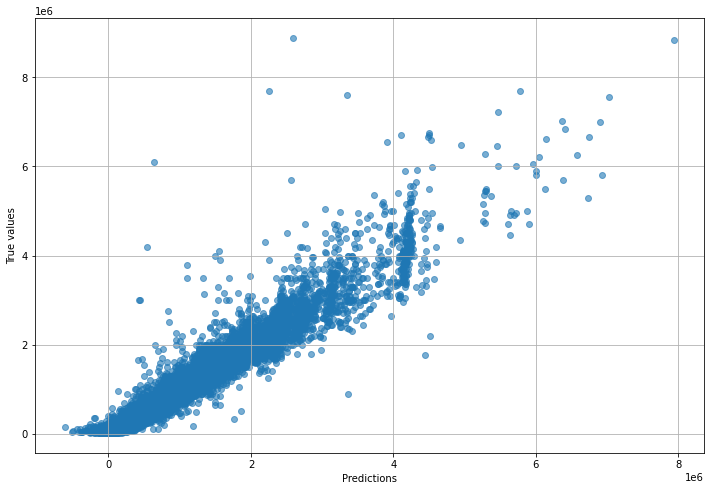

In [23]:
plot_prediction(predictions, y_test)

### 3.3. RandomForestRegressor

In [53]:
# param_grid = {'n_estimators': [100],
#              'max_depth': [10],
#              'min_samples_leaf': [10]}
# grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=param_grid, cv=4)

In [25]:
%%time
rfr = RandomForestRegressor(n_estimators=1000, max_depth=5, n_jobs=-1)
rfr.fit(X_train, y_train)

CPU times: user 9h 52min 8s, sys: 1min 27s, total: 9h 53min 36s
Wall time: 53min 15s


In [27]:
predictions = rfr.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 145616.18


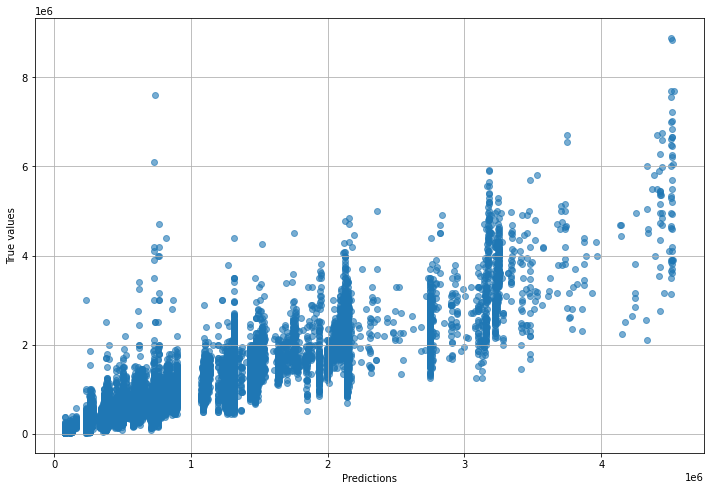

In [28]:
plot_prediction(predictions, y_test)

### 3.4  Boosting models
### 3.4.1 XGBoost

In [46]:
%%time
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

XGBoostError: sklearn needs to be installed in order to use this module

In [38]:
predictions = xgb_model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

NameError: name 'xgb_model' is not defined

In [ ]:
plot_prediction(predictions, y_test)

### 3.4.2 LightGBM

In [19]:
%%time
lgbm_model = LGBMRegressor(n_estimators=1000)
lgbm_model.fit(X_train.values, y_train)

CPU times: user 1min 15s, sys: 2min 1s, total: 3min 16s
Wall time: 2min 58s


In [44]:
predictions = lgbm_model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 62460.11


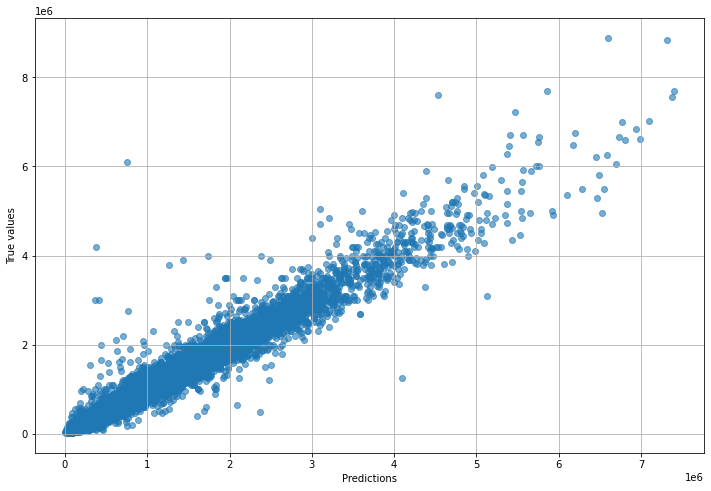

In [33]:
plot_prediction(predictions, y_test)

### 3.4.3 Catboost

In [30]:
%%time
cat_boost = CatBoostRegressor(n_estimators=1000, learning_rate=0.5, silent=True)
cat_boost.fit(X_train.values, y_train)

CPU times: user 5min 32s, sys: 15.2 s, total: 5min 47s
Wall time: 2min 38s


In [43]:
predictions = cat_boost.predict(X_test.values)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 66007.81


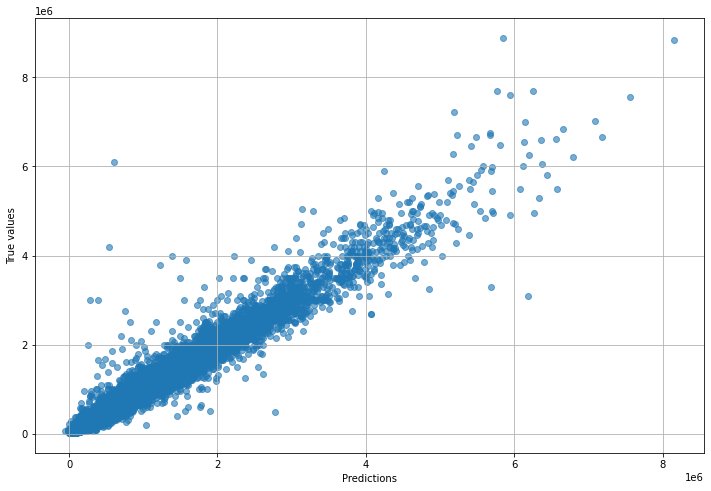

In [36]:
plot_prediction(predictions, y_test)

## TODO:

1. Конструирование новых признаков
2. "Посмотреть" на наблюдения ни которых модели ошибаются - как они пересекаются между собой
3. "Посмотреть" на наблюдения на которых все модели ошибаются больше всего, выделить их характерные особенности
4. Композиция моделей

In [4]:
# from vininfo import Vin


# def vin_to_dic(vin_no):
#     """Преобразует VIN-номер в словарь параметров автомобиля"""
#     vin_dic = {}
    
#     try:
#         vin_info = Vin(vin_no)

#         vin_dic['checksum_is_ok'] = vin_info.verify_checksum()
#         vin_dic['country'] = vin_info.country
#         vin_dic['manufacturer'] = vin_info.manufacturer
#         vin_dic['region'] = vin_info.region
#         vin_dic['produce_year'] = vin_info.years[0]
#         vin_dic['model_year'] = vin_info.years[1]
#         vin_dic['wmi'] = vin_info.wmi      # всемирный индекс изготовителя
#         vin_dic['vds'] = vin_info.vds[:-1] # технические характеристики автомобиля 
#         vin_dic['vis'] = vin_info.vis      # идентификационный номер автомобиля

#         details = vin_info.details
#         if details:
#             vin_dic['details'] = True
#             vin_dic['body'] = str(details.body)
#             vin_dic['engine'] = str(details.engine)
#             vin_dic['model'] = str(details.model)
#             vin_dic['plant'] = str(details.plant)
#             vin_dic['serial'] = str(details.serial)
#             vin_dic['transmission'] = str(details.transmission)
#         else:
#             vin_dic['details'] = False
            
#             for field in ['body', 'engine', 'model', 'plant', 'serial', 'transmission']:
#                 vin_dic[field] = None
#     except:
#         vin_dic['checksum_is_ok'] = False
    
#     return vin_dic